## Installing and importing required libraries

In [28]:
!pip install torchmetrics
!pip install torchmetrics[image]
!pip install torch-fidelity
!pip install scipy
!pip install pytorch-fid
!pip install torch-summary
!pip install matplotlib==3.5
!pip install captum==0.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 99.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninsta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.0 MB/s eta 0:00:00


In [1]:
import os, sys, itertools, glob, torch, torchvision, random, shutil, uuid, io
import numpy as np 
from numpy import asarray
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.animation import ArtistAnimation
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchvision import datasets, transforms, models
import torchvision.utils as vutils
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, random_split, ConcatDataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

torch.manual_seed(46)
device = "cuda" if torch.cuda.is_available() else "cpu"

from pytorch_fid.fid_score import calculate_fid_given_paths
from torchmetrics.image.fid import FrechetInceptionDistance
fid_sc = FrechetInceptionDistance(normalize=True).to(device)
from torchmetrics.image.inception import InceptionScore
inception_sc = InceptionScore(normalize=True).to(device)

import PIL.Image
from PIL import ImageFile
import IPython.display
from IPython.display import HTML

from captum.attr import visualization as viz
from captum.attr import GuidedGradCam, NoiseTunnel
from matplotlib import cm

c:\Users\aless\AppData\Local\Programs\Python\Python310\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Exploratory Data Analysis

The dataset is divided into train and test, both composed by subfolders where each folder represent a class:

In [ ]:
print('Classes: ', os.listdir("/content/drive/MyDrive/dataset/train"))

Classes:  ['no', 'yes']


Checking the distribution of images is an important step in order to understand if the dataset is balanced:

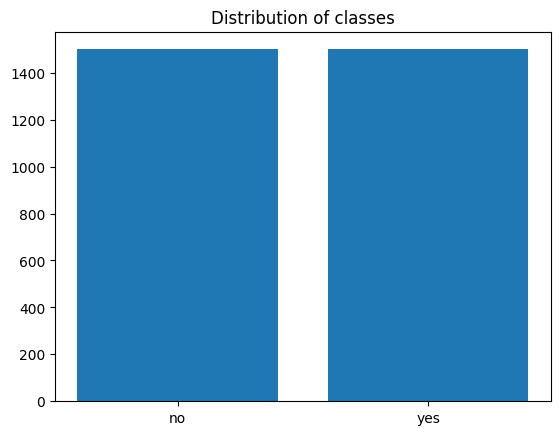

In [ ]:
classes = os.listdir("/content/drive/MyDrive/dataset/train")
sum_images = []
for i in range(2):
    img_base_path = "/content/drive/MyDrive/dataset/train/" + str(classes[i])
    images = os.listdir(img_base_path)
    sum_images.append(len(images))
plt.bar(classes, sum_images)
plt.title('Distribution of classes')
plt.show()

The train set is composed by 1500 normal brain MRI and 1500 tumour brain MRI. The image below shows an example of random images peaked from both classes:

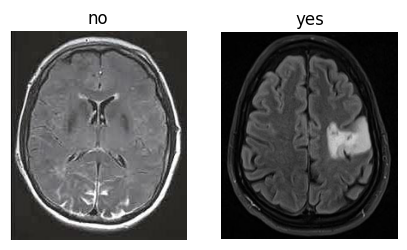

In [ ]:
images = []
paths = []

fig,ax = plt.subplots(1,2,figsize = (5,5))
ax = ax.ravel()

for i in range(2):
    img_base_path = "/content/drive/MyDrive/dataset/train/" + str(classes[i]) 
    timages = os.listdir(img_base_path) 
    images_path_to_display = os.path.join(img_base_path, str(timages[0]))
    paths.append(images_path_to_display)
    img = Image.open(images_path_to_display)
    images.append(img)
    image = images[i]
    ax[i].imshow(image)
    ax[i].set_title(classes[i])
    ax[i].axis('off')

plt.show()

# 1) Conditional Deep Convolutional Generative Adversarial Network

## Data Preprocessing

### Train and Validation Splitting

From the train set 20% of images was randomly extracted to create the validation set, which will be used to compare real and synthetic images in terms of FID and Inception Score. 

In [10]:
data = datasets.ImageFolder('/content/drive/MyDrive/dataset/train')
generator = torch.Generator().manual_seed(46)
train, validation = random_split(data, [0.8, 0.2], generator = generator)
print(len(train))
print(len(validation))

2400
600


In [5]:
class loadData(Dataset):
    def __init__(self, dataset, transform = None):
        self.dataset = dataset
        self.transform = transform
        
    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0])
          
        y = self.dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(self.dataset)

Then, the images was resized to 3 x 64 x 64 to match the computational resources, and normalized with mean and standard deviation of 0.5 to fix the pixels into a range of [-1, 1]. 

In [7]:
train_transform = transforms.Compose([transforms.Resize((64, 64)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

no_transform = transforms.Compose([transforms.Resize((64, 64)),
                                   transforms.ToTensor(), 
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   transforms.ToPILImage()])

In [8]:
trainset = loadData(train, train_transform)
valset = loadData(validation, no_transform)

The validation set is saved into a folder, the model will train on the 80% of images and will compare synthetic images with 20% of saved validation images.

In [ ]:
try:
  os.makedirs('/content/drive/MyDrive/dataset/validation')
except:
  pass
  
for idx in range(len(valset)):
  img, label = valset.__getitem__(idx)
  img.save(f"/content/drive/MyDrive/dataset/validation/{idx}.png")

In [ ]:
print(trainset[0][0].shape, '[channels, height, width]')

torch.Size([3, 64, 64]) [channels, height, width]


### Batches

The images will feed the model with batches of 16 images to ensure a stability and generalization of the model, each batch is shuffled and the last is dropped to ensure that all the batches have the same number of images. As it's possible to see below, the batches has been added as first additional dimention:

In [ ]:
trainloader = DataLoader(trainset, batch_size=16, shuffle=True, drop_last=True)
examples = next(iter(trainloader))
for label, img  in enumerate(examples):
    print(img.shape)

torch.Size([16, 3, 64, 64])
torch.Size([16])


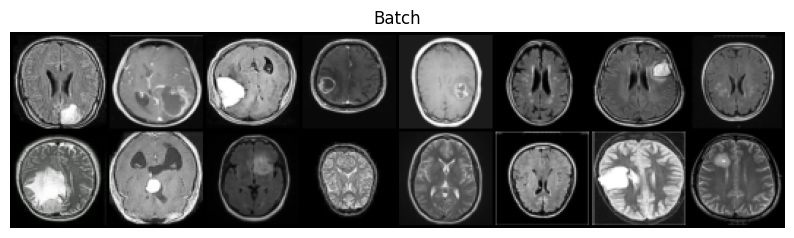

In [ ]:
real_batch = next(iter(trainloader))
plt.figure(figsize=(10, 15))
plt.axis("off")
plt.title("Batch")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:16], padding=2, normalize=True),(1,2,0)))
plt.show()

## LS-WGanGP

For this purpose, I decided to train two types of GAN models: 
* a Wasserstein GAN with Gradient Penalty was used for the discriminator instead of classical DCGAN to avoid mode collapse and to enhace convergence. This type of GAN makes use of the Wasserstein distance and critic loss to discriminate real and fake images, then, a gradient penalty is applied to the weights to allows the functions to be a K-Lipschitz function. 
The objective of the critic loss is to converge to 0, in order to reach the minimum difference between fake and real images. As the discriminator won't discern between 0 and 1 in terms of binary discriminator, in this case the Sigmoid function and the binary crossentropy loss has been deleted, and the model is called Critic instead of Discriminator.  
* a Least Squared GAN has been used for the generator to ensure higher-quality images, penalized otherwise by the usage of WGAN. In this case, the MSE loss is backpropagated throw the generator to compare real and fake images. 

### Discriminator

The discriminator is composed by three blocks: each block contains a convolutional filter, an Instance normalization layer and a Leaky ReLU as an activation function.
* The model receive as input a tensor of shape [16 (batches) x 1 (channel) x 64 (H) x 64 (W)] coming from the Generator plus the embedded condition represented by the label, which pass from the first kernel and produce 64 feature map from a kernel of size 4 and stride of 2 to reduce the spatial dimentions. 
* The first block receive 64 features and produce 128 features map with the same kernel size and the same stride,
* The second block behaves the same and produce 256 feature maps,
* The third block produce 512 feature maps.
Finally, the embed layer allows to concatenate the vector of labels to the image in order to ensure the model to classify images conditioned to the vector of labels. 

### Generator

The generator is made up of 5 blocks. Each block is composed by a transposed convolutional layer, batch normalization layer and ReLU as activation function.
It starts from a random noise of size [batches x 128 x 1 x 1]:
* The first block receive 256 features (coming from the noise + the size of the embedding which during the forward pass will be concatenated) and produce 1024 features with a kernel of size 4, stride 1 and 0 padding (as in this part we don't want to reduce the spatial dimentions),
* The second block receives 1024 features and produces 512 features,
* The third block produces 256 features,
* The fourth block produces 128 features,
* The fifth block produces 64 features, 
* The final layer is a transposed convolutional layer which receive 128 as input and produce 1 output which will fo throw an Hyperbolic tangent activation function. The output will be an image of size 3 x 64 x 64.

In [7]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g, num_classes, img_size, embed_size):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise + embed_size, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )
        self.embed = nn.Embedding(num_classes, embed_size)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x, labels):
      embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
      x = torch.cat([x, embedding], dim=1)
      return self.net(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d, num_classes, img_size):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img+1, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )
        self.embed = nn.Embedding(num_classes, img_size * img_size)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x, labels):
      embedding = self.embed(labels).view(labels.shape[0], 1, self.img_size, self.img_size)
      x = torch.cat([x, embedding], dim=1)
      return self.disc(x)

The weights are not randomly initialized in this case, but with a distribution of mean 0 and standard deviation 0.02, as the official paper suggests. 

In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

The models have been trained for 200 epochs, early stopped for convergence reached. The noise vector has a size of 128 and the critic has been trained three times more than the generator to ensure diversity of images, with a lambda as penalty on the gradients of 10. 

In [ ]:
# Hyperparameters etc.
img_size = 64
channels_img = 3
num_classes = 2
gen_embedding = 128
z_dim = 128
num_epochs = 200
lambda_gp = 10
features_d = 64
features_g = 64
critic_iter = 3

In [ ]:
#channels_noise, channels_img, features_g, num_classes, img_size, embed_size
gen = Generator(z_dim, channels_img, features_g, num_classes, img_size, gen_embedding).to(device)
#channels_img, features_d, num_classes, img_size
critic = Discriminator(channels_img, features_d, num_classes, img_size).to(device)
initialize_weights(gen) #initialize with 0 mean and 0.02 std
initialize_weights(critic) #initialize with 0 mean and 0.02 std

In [ ]:
summary(gen)
summary(critic)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─ConvTranspose2d: 3-1         4,194,304
|    |    └─BatchNorm2d: 3-2             2,048
|    |    └─ReLU: 3-3                    --
|    └─Sequential: 2-2                   --
|    |    └─ConvTranspose2d: 3-4         8,388,608
|    |    └─BatchNorm2d: 3-5             1,024
|    |    └─ReLU: 3-6                    --
|    └─Sequential: 2-3                   --
|    |    └─ConvTranspose2d: 3-7         2,097,152
|    |    └─BatchNorm2d: 3-8             512
|    |    └─ReLU: 3-9                    --
|    └─Sequential: 2-4                   --
|    |    └─ConvTranspose2d: 3-10        524,288
|    |    └─BatchNorm2d: 3-11            256
|    |    └─ReLU: 3-12                   --
|    └─ConvTranspose2d: 2-5              6,147
|    └─Tanh: 2-6                         --
├─Embedding: 1-2                         256
Total params: 15,214,595
Trainabl

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       4,160
|    └─LeakyReLU: 2-2                    --
|    └─Sequential: 2-3                   --
|    |    └─Conv2d: 3-1                  131,072
|    |    └─InstanceNorm2d: 3-2          --
|    |    └─LeakyReLU: 3-3               --
|    └─Sequential: 2-4                   --
|    |    └─Conv2d: 3-4                  524,288
|    |    └─InstanceNorm2d: 3-5          --
|    |    └─LeakyReLU: 3-6               --
|    └─Sequential: 2-5                   --
|    |    └─Conv2d: 3-7                  2,097,152
|    |    └─InstanceNorm2d: 3-8          --
|    |    └─LeakyReLU: 3-9               --
|    └─Conv2d: 2-6                       8,193
├─Embedding: 1-2                         8,192
Total params: 2,773,057
Trainable params: 2,773,057
Non-trainable params: 0

## Training

### Gradient Penalty

The gradient penalty is applied to the critic loss of discriminator as a regularization technique, which allows to promote quality and diversity of images avoiding mode collapse. 

In [ ]:
def gradient_penalty(critic, labels, real, fake, device="cpu"):
    batch_size, C, H, W = real.shape
    alpha = torch.rand((batch_size, 1, 1, 1)).repeat(1, C, H, W).to(device)

    # Compute interpolated images
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, labels)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

As optimizers, Adam has been selected for  both the generator and discriminator, with learning rate of 0.0002, beta1 of 0.5 and beta2 of 0.99 for the former and learning rate of 0.0001, beta1 of 0 and beta2 of 0.9 for the latter.  

In [ ]:
lossG = nn.MSELoss() #Generator loss MSE according to LSGAN
opt_gen = optim.Adam(gen.parameters(), lr=0.0002, betas = (0.5, 0.99)) #Generator optimizer: Adam with lr = 2e-4, b1 = 0.5, b2 = 0.99
opt_critic = optim.Adam(critic.parameters(), lr=0.0001, betas=(0.0, 0.9)) #Discriminator optimizer: Adam with lr = 1e-4, b1 = 0, b2 = 0.9

In [ ]:
gen.train()
critic.train()

losses_critic = [] #Store Discriminator loss
losses_gen = [] #Store Generator loss
fid_scores = [] #Store FID Score
fake_imgs = [] #Store the fake grid throw epochs

for epoch in range(num_epochs): #iterate throw 500 epochs
    for batch_idx, (real, labels) in enumerate(trainloader): #iterate throw each batch every epoch
        real = real.to(device) #real images to GPU
        cur_batch_size = real.shape[0] #save the batch size
        labels = labels.to(device) #labels to GPU

        # Train Critic: WGAN-GP Critic loss + Gradient Penalty
        #minimizing the difference between real and fake 
        #according to the critic loss and gradient penalty
        for _ in range(critic_iter): #train discriminator 3 times more than generator
          noise = torch.randn(cur_batch_size, z_dim, 1, 1).to(device) #make noise of shape [N (batch) * 128 * 1 * 1] and move to GPU
          fake = gen(noise, labels) #generate fake images passing noise and labels to generator
          critic_real = critic(real, labels).reshape(-1) #generate response from discriminatr regarding real 
          critic_fake = critic(fake, labels).reshape(-1) #generate response from discriminator regarding fake
          gp = gradient_penalty(critic, labels, real, fake, device=device) #apply gradient penalty 
          loss_critic = (-(torch.mean(critic_real) - torch.mean(critic_fake)) + lambda_gp *gp) #compute critic loss with gradient penalty regularization
          losses_critic.append(loss_critic.item()) #save and backpropagate
          critic.zero_grad()
          loss_critic.backward(retain_graph=True)
          opt_critic.step()

        # Train Generator: LSGAN (Backpropagation of MSE throw generator allows to reach higher quality images)
        # minimize the MSE 
        real_target = torch.full((cur_batch_size,), 1., device=device) #Generate real label tensor         
        gen.zero_grad() 
        output = critic(fake, labels).reshape(-1) #generate response regarding fake 
        errG = lossG(output, real_target) #compute MSE between fake and real 
        errG.backward() #Backpropagate the error throw the generator
        D_G_z2 = output.mean().item() 
        opt_gen.step()
        losses_gen.append(D_G_z2)

    #Eval
    try:
      os.makedirs('tmp')
    except:
      pass

    with torch.no_grad():
      #create grid of synthetic images
      fake = gen(noise, labels)
      img_grid_fake = torchvision.utils.make_grid(fake.cpu(), normalize=True)
      vutils.save_image(img_grid_fake, '/content/drive/MyDrive/fake_samples_epoch_%03d.png' % (epoch))
      fake_imgs.append(img_grid_fake)

      #create batches of synthetic images          
      noise_val = torch.randn(600, z_dim, 1, 1, device=device)
      labels_val = torch.randint(0, num_classes, (600,), device=device)
      fake_imgs_val = gen(noise_val, labels_val)

    #save synthetic images on tmp
    for idx in range(fake_imgs_val.shape[0]):
      fake_img_val = fake_imgs_val[idx]
      vutils.save_image(fake_img_val, f"tmp/{str(uuid.uuid4())}.png",normalize=True)

    #fid (synthetic vs validation)
    fid = calculate_fid_given_paths(['/content/drive/MyDrive/dataset/validation','tmp'], dims=2048, device = device, batch_size=16)
    fid_scores.append(fid)
    shutil.rmtree('tmp')

    #print loss
    print(f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(trainloader)} Critic Loss: {loss_critic.item():.4f}, Generator Loss: {D_G_z2:.4f}, FID: {fid:.4f}")

    
    #save to retrain
    state1 = {
        'epoch': epoch,
        'state_dict': gen.state_dict(),
        'optimizer': opt_gen.state_dict(),
        'loss': D_G_z2}
    torch.save(state1, '/content/drive/MyDrive/generator.pth')

    state2 = {
        'epoch': epoch,
        'state_dict': critic.state_dict(),
        'optimizer': opt_critic.state_dict(),
        'loss': loss_critic}
    torch.save(state2, '/content/drive/MyDrive/critic.pth')

100%|██████████| 38/38 [00:02<00:00, 13.38it/s]


Epoch [0/200] Batch 149/150 Critic Loss: -35.8893, Generator Loss: -85.8455, FID: 268.5700


100%|██████████| 38/38 [00:02<00:00, 14.90it/s]


Epoch [1/200] Batch 149/150 Critic Loss: -31.6993, Generator Loss: -85.6984, FID: 253.8937


100%|██████████| 38/38 [00:02<00:00, 15.26it/s]


Epoch [2/200] Batch 149/150 Critic Loss: -35.1335, Generator Loss: -88.1315, FID: 211.7122


100%|██████████| 38/38 [00:02<00:00, 14.98it/s]


Epoch [3/200] Batch 149/150 Critic Loss: -27.9964, Generator Loss: -88.9243, FID: 189.3613


100%|██████████| 38/38 [00:02<00:00, 14.57it/s]


Epoch [4/200] Batch 149/150 Critic Loss: -22.6363, Generator Loss: -90.2069, FID: 154.7251


100%|██████████| 38/38 [00:02<00:00, 15.04it/s]


Epoch [5/200] Batch 149/150 Critic Loss: -18.8460, Generator Loss: -86.3670, FID: 159.5882


100%|██████████| 38/38 [00:02<00:00, 13.79it/s]


Epoch [6/200] Batch 149/150 Critic Loss: -22.0099, Generator Loss: -85.0115, FID: 145.7352


100%|██████████| 38/38 [00:02<00:00, 15.02it/s]


Epoch [7/200] Batch 149/150 Critic Loss: -15.7427, Generator Loss: -88.6061, FID: 142.3962


100%|██████████| 38/38 [00:02<00:00, 14.99it/s]


Epoch [8/200] Batch 149/150 Critic Loss: -21.6841, Generator Loss: -105.9087, FID: 135.8785


100%|██████████| 38/38 [00:02<00:00, 14.05it/s]


Epoch [9/200] Batch 149/150 Critic Loss: -18.4917, Generator Loss: -111.0073, FID: 146.9128


100%|██████████| 38/38 [00:02<00:00, 15.02it/s]


Epoch [10/200] Batch 149/150 Critic Loss: -22.3988, Generator Loss: -105.7505, FID: 136.9758


100%|██████████| 38/38 [00:02<00:00, 13.87it/s]


Epoch [11/200] Batch 149/150 Critic Loss: -21.3806, Generator Loss: -116.8271, FID: 140.7680


100%|██████████| 38/38 [00:02<00:00, 14.97it/s]


Epoch [12/200] Batch 149/150 Critic Loss: -23.9256, Generator Loss: -117.0514, FID: 145.5479


100%|██████████| 38/38 [00:02<00:00, 15.15it/s]


Epoch [13/200] Batch 149/150 Critic Loss: -23.9419, Generator Loss: -105.3592, FID: 144.3895


100%|██████████| 38/38 [00:02<00:00, 13.88it/s]


Epoch [14/200] Batch 149/150 Critic Loss: -28.2315, Generator Loss: -117.2295, FID: 136.3877


100%|██████████| 38/38 [00:02<00:00, 15.00it/s]


Epoch [15/200] Batch 149/150 Critic Loss: -24.6066, Generator Loss: -112.6196, FID: 137.5525


100%|██████████| 38/38 [00:02<00:00, 13.81it/s]


Epoch [16/200] Batch 149/150 Critic Loss: -22.8535, Generator Loss: -124.7229, FID: 134.5310


100%|██████████| 38/38 [00:02<00:00, 15.18it/s]


Epoch [17/200] Batch 149/150 Critic Loss: -19.2698, Generator Loss: -119.5326, FID: 134.6592


100%|██████████| 38/38 [00:02<00:00, 14.98it/s]


Epoch [18/200] Batch 149/150 Critic Loss: -19.0743, Generator Loss: -120.0613, FID: 129.3728


100%|██████████| 38/38 [00:02<00:00, 13.75it/s]


Epoch [19/200] Batch 149/150 Critic Loss: -17.6343, Generator Loss: -131.7356, FID: 123.9713


100%|██████████| 38/38 [00:02<00:00, 14.91it/s]


Epoch [20/200] Batch 149/150 Critic Loss: -22.5295, Generator Loss: -125.9715, FID: 139.5422


100%|██████████| 38/38 [00:02<00:00, 15.00it/s]


Epoch [21/200] Batch 149/150 Critic Loss: -21.3077, Generator Loss: -129.1101, FID: 133.4700


100%|██████████| 38/38 [00:02<00:00, 14.70it/s]


Epoch [22/200] Batch 149/150 Critic Loss: -18.6725, Generator Loss: -122.5965, FID: 131.1919


100%|██████████| 38/38 [00:02<00:00, 14.95it/s]


Epoch [23/200] Batch 149/150 Critic Loss: -29.4854, Generator Loss: -127.7179, FID: 129.2103


100%|██████████| 38/38 [00:02<00:00, 13.79it/s]


Epoch [24/200] Batch 149/150 Critic Loss: -23.2654, Generator Loss: -121.9320, FID: 131.3566


100%|██████████| 38/38 [00:02<00:00, 14.94it/s]


Epoch [25/200] Batch 149/150 Critic Loss: -20.0660, Generator Loss: -138.4439, FID: 138.9682


100%|██████████| 38/38 [00:02<00:00, 14.91it/s]


Epoch [26/200] Batch 149/150 Critic Loss: -23.8176, Generator Loss: -134.1684, FID: 130.6023


100%|██████████| 38/38 [00:02<00:00, 13.73it/s]


Epoch [27/200] Batch 149/150 Critic Loss: -23.0087, Generator Loss: -131.5987, FID: 131.9063


100%|██████████| 38/38 [00:02<00:00, 15.11it/s]


Epoch [28/200] Batch 149/150 Critic Loss: -20.0276, Generator Loss: -137.3956, FID: 125.6199


100%|██████████| 38/38 [00:02<00:00, 15.25it/s]


Epoch [29/200] Batch 149/150 Critic Loss: -18.9153, Generator Loss: -134.4700, FID: 136.9471


100%|██████████| 38/38 [00:02<00:00, 14.96it/s]


Epoch [30/200] Batch 149/150 Critic Loss: -24.9721, Generator Loss: -137.1067, FID: 133.1768


100%|██████████| 38/38 [00:02<00:00, 15.34it/s]


Epoch [31/200] Batch 149/150 Critic Loss: -18.2612, Generator Loss: -144.2305, FID: 128.5328


100%|██████████| 38/38 [00:02<00:00, 14.21it/s]


Epoch [32/200] Batch 149/150 Critic Loss: -22.6255, Generator Loss: -146.9761, FID: 139.6025


100%|██████████| 38/38 [00:02<00:00, 15.42it/s]


Epoch [33/200] Batch 149/150 Critic Loss: -32.1192, Generator Loss: -144.1576, FID: 133.3195


100%|██████████| 38/38 [00:02<00:00, 13.64it/s]


Epoch [34/200] Batch 149/150 Critic Loss: -21.2082, Generator Loss: -147.8428, FID: 130.0949


100%|██████████| 38/38 [00:02<00:00, 15.33it/s]


Epoch [35/200] Batch 149/150 Critic Loss: -20.8661, Generator Loss: -149.1281, FID: 135.4750


100%|██████████| 38/38 [00:02<00:00, 14.63it/s]


Epoch [36/200] Batch 149/150 Critic Loss: -22.8561, Generator Loss: -143.6547, FID: 133.7009


100%|██████████| 38/38 [00:02<00:00, 15.19it/s]


Epoch [37/200] Batch 149/150 Critic Loss: -24.0481, Generator Loss: -138.9655, FID: 133.9875


100%|██████████| 38/38 [00:02<00:00, 15.04it/s]


Epoch [38/200] Batch 149/150 Critic Loss: -21.9649, Generator Loss: -157.0659, FID: 128.0428


100%|██████████| 38/38 [00:02<00:00, 14.67it/s]


Epoch [39/200] Batch 149/150 Critic Loss: -24.0771, Generator Loss: -148.3558, FID: 130.2133


100%|██████████| 38/38 [00:02<00:00, 15.00it/s]


Epoch [40/200] Batch 149/150 Critic Loss: -32.8516, Generator Loss: -149.1929, FID: 133.0826


100%|██████████| 38/38 [00:02<00:00, 14.23it/s]


Epoch [41/200] Batch 149/150 Critic Loss: -29.4208, Generator Loss: -148.8808, FID: 130.8663


100%|██████████| 38/38 [00:02<00:00, 14.99it/s]


Epoch [42/200] Batch 149/150 Critic Loss: -22.4364, Generator Loss: -158.2649, FID: 130.8910


100%|██████████| 38/38 [00:02<00:00, 14.56it/s]


Epoch [43/200] Batch 149/150 Critic Loss: -22.1620, Generator Loss: -147.3150, FID: 134.8743


100%|██████████| 38/38 [00:02<00:00, 14.81it/s]


Epoch [44/200] Batch 149/150 Critic Loss: -21.7783, Generator Loss: -149.5377, FID: 137.3329


100%|██████████| 38/38 [00:02<00:00, 14.99it/s]


Epoch [45/200] Batch 149/150 Critic Loss: -27.8341, Generator Loss: -160.2489, FID: 138.5404


100%|██████████| 38/38 [00:02<00:00, 14.49it/s]


Epoch [46/200] Batch 149/150 Critic Loss: -23.9310, Generator Loss: -148.5682, FID: 130.8915


100%|██████████| 38/38 [00:02<00:00, 15.00it/s]


Epoch [47/200] Batch 149/150 Critic Loss: -27.9342, Generator Loss: -144.7182, FID: 136.3620


100%|██████████| 38/38 [00:02<00:00, 13.65it/s]


Epoch [48/200] Batch 149/150 Critic Loss: -26.8273, Generator Loss: -148.6764, FID: 144.0185


100%|██████████| 38/38 [00:02<00:00, 15.02it/s]


Epoch [49/200] Batch 149/150 Critic Loss: -28.4861, Generator Loss: -151.8611, FID: 142.5673


100%|██████████| 38/38 [00:02<00:00, 13.83it/s]


Epoch [50/200] Batch 149/150 Critic Loss: -22.7777, Generator Loss: -152.9772, FID: 138.8828


100%|██████████| 38/38 [00:02<00:00, 15.10it/s]


Epoch [51/200] Batch 149/150 Critic Loss: -25.4031, Generator Loss: -157.5347, FID: 138.0258


100%|██████████| 38/38 [00:02<00:00, 13.83it/s]


Epoch [52/200] Batch 149/150 Critic Loss: -26.5536, Generator Loss: -165.7221, FID: 134.5991


100%|██████████| 38/38 [00:02<00:00, 14.97it/s]


Epoch [53/200] Batch 149/150 Critic Loss: -23.7534, Generator Loss: -161.6628, FID: 142.8368


100%|██████████| 38/38 [00:02<00:00, 15.02it/s]


Epoch [54/200] Batch 149/150 Critic Loss: -27.6581, Generator Loss: -156.5188, FID: 134.1318


100%|██████████| 38/38 [00:02<00:00, 14.81it/s]


Epoch [55/200] Batch 149/150 Critic Loss: -18.2370, Generator Loss: -158.5740, FID: 133.6341


100%|██████████| 38/38 [00:02<00:00, 14.95it/s]


Epoch [56/200] Batch 149/150 Critic Loss: -23.7177, Generator Loss: -156.5172, FID: 138.4712


100%|██████████| 38/38 [00:02<00:00, 13.49it/s]


Epoch [57/200] Batch 149/150 Critic Loss: -29.9874, Generator Loss: -155.6298, FID: 134.9646


100%|██████████| 38/38 [00:02<00:00, 14.96it/s]


Epoch [58/200] Batch 149/150 Critic Loss: -13.1184, Generator Loss: -160.3655, FID: 139.7587


100%|██████████| 38/38 [00:02<00:00, 14.30it/s]


Epoch [59/200] Batch 149/150 Critic Loss: -26.3501, Generator Loss: -162.1340, FID: 130.1382


100%|██████████| 38/38 [00:02<00:00, 14.97it/s]


Epoch [60/200] Batch 149/150 Critic Loss: -26.3572, Generator Loss: -164.0021, FID: 136.1833


100%|██████████| 38/38 [00:02<00:00, 14.90it/s]


Epoch [61/200] Batch 149/150 Critic Loss: -23.9657, Generator Loss: -162.4155, FID: 141.7322


100%|██████████| 38/38 [00:02<00:00, 14.37it/s]


Epoch [62/200] Batch 149/150 Critic Loss: -25.5563, Generator Loss: -152.8572, FID: 131.8526


100%|██████████| 38/38 [00:02<00:00, 14.98it/s]


Epoch [63/200] Batch 149/150 Critic Loss: -27.9644, Generator Loss: -154.7130, FID: 135.8494


100%|██████████| 38/38 [00:02<00:00, 13.47it/s]


Epoch [64/200] Batch 149/150 Critic Loss: -22.7029, Generator Loss: -160.3159, FID: 134.7661


100%|██████████| 38/38 [00:02<00:00, 13.79it/s]


Epoch [65/200] Batch 149/150 Critic Loss: -29.1965, Generator Loss: -153.0272, FID: 128.6277


100%|██████████| 38/38 [00:02<00:00, 12.70it/s]


Epoch [66/200] Batch 149/150 Critic Loss: -30.3731, Generator Loss: -151.7702, FID: 131.3640


100%|██████████| 38/38 [00:02<00:00, 14.89it/s]


Epoch [67/200] Batch 149/150 Critic Loss: -20.3164, Generator Loss: -163.9485, FID: 135.3387


100%|██████████| 38/38 [00:02<00:00, 14.73it/s]


Epoch [68/200] Batch 149/150 Critic Loss: -24.0920, Generator Loss: -162.8640, FID: 136.7671


100%|██████████| 38/38 [00:02<00:00, 14.77it/s]


Epoch [69/200] Batch 149/150 Critic Loss: -19.8530, Generator Loss: -167.6770, FID: 129.6751


100%|██████████| 38/38 [00:02<00:00, 14.98it/s]


Epoch [70/200] Batch 149/150 Critic Loss: -27.4611, Generator Loss: -161.2199, FID: 133.9353


100%|██████████| 38/38 [00:02<00:00, 13.86it/s]


Epoch [71/200] Batch 149/150 Critic Loss: -27.3314, Generator Loss: -169.3531, FID: 138.7131


100%|██████████| 38/38 [00:02<00:00, 14.98it/s]


Epoch [72/200] Batch 149/150 Critic Loss: -22.2601, Generator Loss: -167.1821, FID: 132.6360


100%|██████████| 38/38 [00:02<00:00, 14.10it/s]


Epoch [73/200] Batch 149/150 Critic Loss: -32.8146, Generator Loss: -153.3998, FID: 137.6839


100%|██████████| 38/38 [00:02<00:00, 14.95it/s]


Epoch [74/200] Batch 149/150 Critic Loss: -30.2031, Generator Loss: -156.0752, FID: 131.9328


100%|██████████| 38/38 [00:02<00:00, 15.10it/s]


Epoch [75/200] Batch 149/150 Critic Loss: -17.8537, Generator Loss: -151.8268, FID: 132.0923


100%|██████████| 38/38 [00:02<00:00, 14.75it/s]


Epoch [76/200] Batch 149/150 Critic Loss: -24.7328, Generator Loss: -168.3387, FID: 128.3261


100%|██████████| 38/38 [00:02<00:00, 14.97it/s]


Epoch [77/200] Batch 149/150 Critic Loss: -31.3159, Generator Loss: -160.5876, FID: 132.9779


100%|██████████| 38/38 [00:02<00:00, 13.93it/s]


Epoch [78/200] Batch 149/150 Critic Loss: -20.5610, Generator Loss: -163.1920, FID: 138.8265


100%|██████████| 38/38 [00:02<00:00, 14.02it/s]


Epoch [79/200] Batch 149/150 Critic Loss: -40.1705, Generator Loss: -160.5777, FID: 137.9721


100%|██████████| 38/38 [00:02<00:00, 14.93it/s]


Epoch [80/200] Batch 149/150 Critic Loss: -22.7610, Generator Loss: -170.4523, FID: 137.5366


100%|██████████| 38/38 [00:02<00:00, 13.77it/s]


Epoch [81/200] Batch 149/150 Critic Loss: -25.8557, Generator Loss: -161.5666, FID: 132.0567


100%|██████████| 38/38 [00:02<00:00, 14.86it/s]


Epoch [82/200] Batch 149/150 Critic Loss: -31.1080, Generator Loss: -173.3194, FID: 134.4282


100%|██████████| 38/38 [00:02<00:00, 13.76it/s]


Epoch [83/200] Batch 149/150 Critic Loss: -25.6349, Generator Loss: -168.4322, FID: 131.0658


100%|██████████| 38/38 [00:02<00:00, 14.89it/s]


Epoch [84/200] Batch 149/150 Critic Loss: -23.1723, Generator Loss: -159.6405, FID: 123.4332


100%|██████████| 38/38 [00:02<00:00, 14.97it/s]


Epoch [85/200] Batch 149/150 Critic Loss: -29.7734, Generator Loss: -159.9643, FID: 133.5069


100%|██████████| 38/38 [00:02<00:00, 13.54it/s]


Epoch [86/200] Batch 149/150 Critic Loss: -28.1291, Generator Loss: -165.9061, FID: 136.3247


100%|██████████| 38/38 [00:02<00:00, 14.98it/s]


Epoch [87/200] Batch 149/150 Critic Loss: -26.6549, Generator Loss: -154.7205, FID: 133.1771


100%|██████████| 38/38 [00:02<00:00, 14.20it/s]


Epoch [88/200] Batch 149/150 Critic Loss: -23.7874, Generator Loss: -163.5975, FID: 142.5766


100%|██████████| 38/38 [00:02<00:00, 14.96it/s]


Epoch [89/200] Batch 149/150 Critic Loss: -24.2447, Generator Loss: -173.9509, FID: 129.5340


100%|██████████| 38/38 [00:02<00:00, 14.97it/s]


Epoch [90/200] Batch 149/150 Critic Loss: -43.3206, Generator Loss: -152.6250, FID: 137.6434


100%|██████████| 38/38 [00:02<00:00, 14.63it/s]


Epoch [91/200] Batch 149/150 Critic Loss: -33.6935, Generator Loss: -157.9830, FID: 128.2912


100%|██████████| 38/38 [00:02<00:00, 14.94it/s]


Epoch [92/200] Batch 149/150 Critic Loss: -31.0950, Generator Loss: -151.0320, FID: 137.2950


100%|██████████| 38/38 [00:02<00:00, 13.73it/s]


Epoch [93/200] Batch 149/150 Critic Loss: -24.7499, Generator Loss: -164.1028, FID: 139.3531


100%|██████████| 38/38 [00:02<00:00, 14.82it/s]


Epoch [94/200] Batch 149/150 Critic Loss: -27.0383, Generator Loss: -166.0846, FID: 138.4568


100%|██████████| 38/38 [00:02<00:00, 13.84it/s]


Epoch [95/200] Batch 149/150 Critic Loss: -28.3576, Generator Loss: -163.9502, FID: 133.1777


100%|██████████| 38/38 [00:02<00:00, 14.92it/s]


Epoch [96/200] Batch 149/150 Critic Loss: -26.5608, Generator Loss: -171.3646, FID: 131.7292


100%|██████████| 38/38 [00:02<00:00, 14.74it/s]


Epoch [97/200] Batch 149/150 Critic Loss: -31.4621, Generator Loss: -164.7654, FID: 137.2918


100%|██████████| 38/38 [00:02<00:00, 14.94it/s]


Epoch [98/200] Batch 149/150 Critic Loss: -30.0120, Generator Loss: -180.4283, FID: 130.6966


100%|██████████| 38/38 [00:02<00:00, 14.98it/s]


Epoch [99/200] Batch 149/150 Critic Loss: -34.1868, Generator Loss: -163.3759, FID: 134.2706


100%|██████████| 38/38 [00:02<00:00, 14.45it/s]


Epoch [100/200] Batch 149/150 Critic Loss: -29.3586, Generator Loss: -164.5898, FID: 136.2277


100%|██████████| 38/38 [00:02<00:00, 14.84it/s]


Epoch [101/200] Batch 149/150 Critic Loss: -24.4106, Generator Loss: -167.7723, FID: 139.7413


100%|██████████| 38/38 [00:02<00:00, 13.97it/s]


Epoch [102/200] Batch 149/150 Critic Loss: -28.4934, Generator Loss: -158.1613, FID: 128.2644


KeyboardInterrupt: ignored

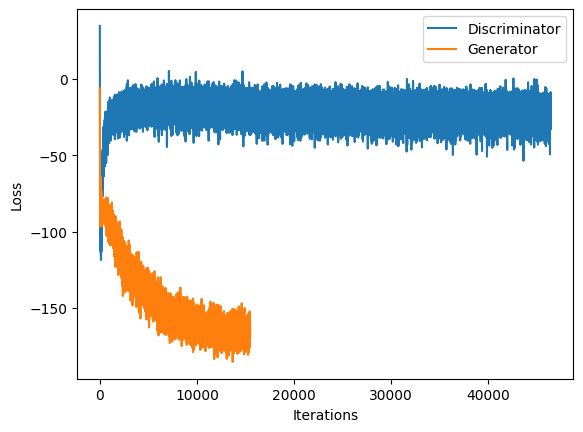

In [ ]:
plt.plot(losses_critic, label = 'Discriminator')
plt.plot(losses_gen, label = 'Generator')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

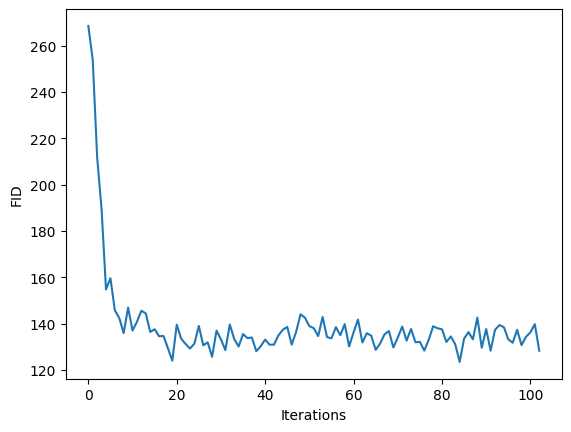

In [ ]:
plt.plot(fid_scores)
plt.xlabel('Iterations')
plt.ylabel('FID')
plt.show()

## Evaluation

In [12]:
#torch.save(gen, '/content/drive/MyDrive/gen_gan.pth')
# Load the trained generator model
generator = torch.load('/content/drive/MyDrive/gen_gan.pth', map_location = torch.device('cpu'))
generator.to(device)
generator.eval()

Generator(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(256, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(128, 3, 

The code below allows to create a ".gif" composed by all the frames created during training:

In [ ]:
directory = '/content/drive/MyDrive/fake_frames/'
image_files = [os.path.join(directory, filename) for filename in os.listdir(directory) if filename.endswith('.png')]
image_files.sort()
frames = []

for image_file in image_files:
    image = Image.open(image_file)
    frames.append(image)

output_file = '/content/drive/MyDrive/fake_frames/output.gif'
frames[0].save(output_file, format='GIF', append_images=frames[1:], save_all=True, duration=500, loop=0)


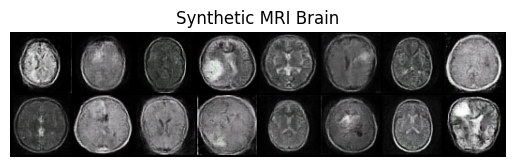

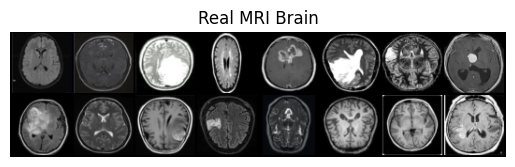

FID:  tensor(106.7613, device='cuda:0')
Inception Score:  (tensor(1.6890, device='cuda:0'), tensor(0.0400, device='cuda:0'))


In [16]:
no_transform = transforms.Compose([transforms.Resize((64, 64)),
                                   transforms.ToTensor(), 
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

validation.dataset.transform = no_transform
validloader = DataLoader(validation, batch_size = 600, shuffle = True)

#Create synthetic normal brain
z = torch.randn(600, 128, 1, 1).to(device)
label = torch.tensor([0, 1]).to(device)
label = label.repeat(300)

# Generate fake images from the noise and labels using the generator
fake_images = generator(z, label)
# Rescale the pixel values from [-1, 1] to [0, 1] 
fake_images = (fake_images + 1) / 2

grid = torchvision.utils.make_grid(fake_images[:16].cpu(), normalize=True)
# Convert the grid tensor to a numpy array and transpose it
grid_np = grid.detach().cpu().numpy().transpose((1, 2, 0))
# Display the grid of generated images
plt.imshow(grid_np)
plt.title('Synthetic MRI Brain')
plt.axis('off')
plt.show()

val_batch = next(iter(validloader))
val_batch = (val_batch[0] + 1) / 2
plt.axis("off")
plt.title("Real MRI Brain")
plt.imshow(np.transpose(vutils.make_grid(val_batch[:16], padding=2, normalize=True),(1,2,0)))
plt.show()

fake_images = fake_images.to(device)
val_batch = val_batch.to(device)
fid_sc.update(val_batch.to(dtype=torch.float), real=True)
fid_sc.update(fake_images.to(dtype=torch.float), real=False)
fid_score = fid_sc.compute()
print('FID: ', fid_score)

inception_sc.update(fake_images.to(dtype=torch.float))
inception = inception_sc.compute()
print('Inception Score: ', inception)

Images above shows synthetic images compared to real images coming from the validation set. The FID and Inception Score has been computed on the whole set and compared with the same number of synthetic images to have a general overview: the FID score, which compares the distribution of real and fake images, is 106.76; the Inception Score, which compares variety and diversity within the dataset, is 1.69 over 2, with a standard deviation of 0.04.  

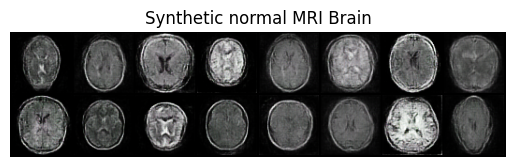

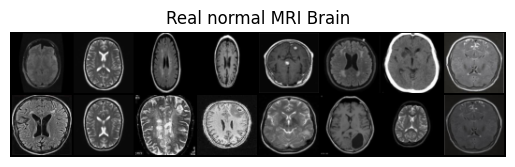

FID:  107.61514282226562


In [32]:
#Select normal brain for validation
no = 0
validation.dataset.transform = no_transform
indices = [i for i, (_, label) in enumerate(validation) if label == no]
subset = torch.utils.data.Subset(validation, indices)
real_no_loader = DataLoader(subset, batch_size = 300, shuffle = True)

#Create synthetic normal brain
z = torch.randn(300, 128, 1, 1)
label = torch.tensor([0])
label = label.repeat(300)

# Generate fake images from the noise and labels using the generator
fake_no_images = generator(z, label)

# Rescale the pixel values from [-1, 1] to [0, 1] for visualization and saving
fake_no_images = (fake_no_images + 1) / 2

grid = torchvision.utils.make_grid(fake_no_images[:16].cpu(), normalize=True)
# Convert the grid tensor to a numpy array and transpose it
grid_np = grid.detach().cpu().numpy().transpose((1, 2, 0))
# Display the grid of generated images
plt.imshow(grid_np)
plt.title('Synthetic normal MRI Brain')
plt.axis('off')
plt.show()

val_batch = next(iter(real_no_loader))
plt.axis("off")
plt.title("Real normal MRI Brain")
plt.imshow(np.transpose(vutils.make_grid(val_batch[0][:16], padding=2, normalize=True),(1,2,0)))
plt.show()

real_no_loader = next(iter(real_no_loader))
#range [0, 1] from [-1, 1]
real_no_loader = (real_no_loader[0] + 1) / 2
fid_sc.update(real_no_loader.to(dtype=torch.float), real=True)
fid_sc.update(fake_no_images.to(dtype=torch.float), real=False)
fid_score = fid_sc.compute()
print('FID: ', fid_score.item())

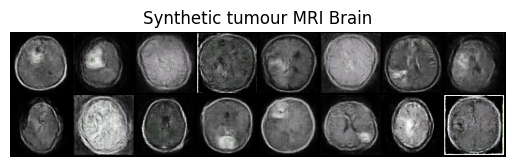

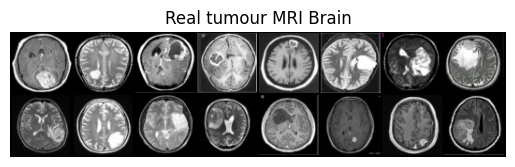

FID:  tensor(104.2167)


In [33]:
#Select normal brain for validation
yes = 1
validation.dataset.transform = no_transform
indices = [i for i, (_, label) in enumerate(validation) if label == yes]
subset = torch.utils.data.Subset(validation, indices)
real_yes_loader = DataLoader(subset, batch_size = 300, shuffle = True)

#Create synthetic normal brain
z = torch.randn(300, 128, 1, 1)
label = torch.tensor([1])
label = label.repeat(300)

# Generate fake images from the noise and labels using the generator
fake_yes_images = generator(z, label)

# Rescale the pixel values from [-1, 1] to [0, 1] for visualization and saving
fake_yes_images = (fake_yes_images + 1) / 2

grid = torchvision.utils.make_grid(fake_yes_images[:16].cpu(), normalize=True)
# Convert the grid tensor to a numpy array and transpose it
grid_np = grid.detach().cpu().numpy().transpose((1, 2, 0))
# Display the grid of generated images
plt.imshow(grid_np)
plt.title('Synthetic tumour MRI Brain')
plt.axis('off')
plt.show()

val_batch = next(iter(real_yes_loader))
plt.axis("off")
plt.title("Real tumour MRI Brain")
plt.imshow(np.transpose(vutils.make_grid(val_batch[0][:16], padding=2, normalize=True),(1,2,0)))
plt.show()

real_yes_loader = next(iter(real_yes_loader))
real_yes_loader = (real_yes_loader[0] + 1) / 2
fid_sc.update(real_yes_loader.to(dtype=torch.float), real=True)
fid_sc.update(fake_yes_images.to(dtype=torch.float), real=False)
fid_score = fid_sc.compute()
print('FID: ', fid_score)

To further inspect the model, FID has been computed on each class separately: real and fake normal MRI produced a FID of 107, real and fake tumour MRI produced a FID of 104. This is a good score as the synthetic tumour images are slightly more similar to the real images in terms of distribution. 

#### Saving synthetic dataset

The synthetic dataset represent 33.3% of the original dataset, as 500 fake images per label has been created and saved into separate folders.

In [ ]:
# Set the desired labels and number of images per label
labels = [0, 1]
images_per_label = 500

# Set the directory to save the generated images
save_dir = "/content/drive/MyDrive/dataset/synthetic_images"
os.makedirs(save_dir, exist_ok=True)

# Generate and save images for each label
for label in labels:
    # Create a tensor for the current label
    label_tensor = torch.tensor([label]).to(device)

    # Generate and save images
    for i in range(images_per_label):
        # Generate a single image
        noise = torch.randn(1, 128, 1, 1).to(device)
        generated_image = generator(noise, label_tensor)

        # Save the generated image
        save_path = os.path.join(save_dir, f"label_{label}_image_{i}.png")
        torchvision.utils.save_image(generated_image, save_path)

        print(f"Saved image: {save_path}")

Saved image: /content/drive/MyDrive/dataset/synthetic_images/label_0_image_0.png
Saved image: /content/drive/MyDrive/dataset/synthetic_images/label_0_image_1.png
Saved image: /content/drive/MyDrive/dataset/synthetic_images/label_0_image_2.png
Saved image: /content/drive/MyDrive/dataset/synthetic_images/label_0_image_3.png
Saved image: /content/drive/MyDrive/dataset/synthetic_images/label_0_image_4.png
Saved image: /content/drive/MyDrive/dataset/synthetic_images/label_0_image_5.png
Saved image: /content/drive/MyDrive/dataset/synthetic_images/label_0_image_6.png
Saved image: /content/drive/MyDrive/dataset/synthetic_images/label_0_image_7.png
Saved image: /content/drive/MyDrive/dataset/synthetic_images/label_0_image_8.png
Saved image: /content/drive/MyDrive/dataset/synthetic_images/label_0_image_9.png
Saved image: /content/drive/MyDrive/dataset/synthetic_images/label_0_image_10.png
Saved image: /content/drive/MyDrive/dataset/synthetic_images/label_0_image_11.png
Saved image: /content/driv

# 2) Classification

## Classification on original dataset

In this first part, the classification on the original dataset has been performed. The validation set has been extracted from the train set with percentage of 80-20. 

In [ ]:
data = datasets.ImageFolder('/content/drive/MyDrive/dataset/train')
generator = torch.Generator().manual_seed(46)
train, validation = random_split(data, [0.8, 0.2], generator = generator)

As the pretrained model requires, the images has been resized to 224 x 224 and normalized according to the measure of Imagenet. Then, the train set has been augmented with random horizontal and vertical flip and random rotation of 15°, the validation set instead has been normalized only. 

In [4]:
traintransform = transforms.Compose([transforms.RandomResizedCrop((224, 224)),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.RandomRotation(15),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5227, 0.4927, 0.4786], std=[0.3068, 0.3044, 0.3066])])

notransform = transforms.Compose([transforms.Resize((224, 224)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5227, 0.4927, 0.4786], std=[0.3068, 0.3044, 0.3066])])

In [ ]:
trainset = loadData(train, transform = traintransform)
valset = loadData(validation, transform = notransform)

For this purpose, a batch of 64 has been selected by shuffling the train loader only. 

In [ ]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, drop_last=True)
validloader = DataLoader(valset, batch_size=64, shuffle=False, drop_last=False)

In [ ]:
model = models.mobilenet_v2(pretrained=True)
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Training

Optimizer choosed for this purpose was Adam with learning rate of 1e-3 and weight decay (L2) of 2e-5 to prevent from overfitting.

In [ ]:
model.classifier[1] = nn.Linear(1280, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 2e-5)

def train(net, loaders, optimizer, criterion, epochs=100, dev=torch.device('cpu')):
    try:
        net = net.to(dev)
        # Initialize history
        history_loss = {"train": [], "val": []}
        history_accuracy = {"train": [], "val": []}
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0}
            sum_accuracy = {"train": 0, "val": 0}
            # Process each split
            for split in ["train", "val"]:
                if split == "train":
                    net.train()
                else:
                    net.eval()
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    outputs = net(input)
                    loss = criterion(outputs, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    preds = torch.argmax(outputs, 1)
                    batch_accuracy = (preds == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val"]}
            # Update history
            for split in ["train", "val"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"Train Loss={epoch_loss['train']:.4f},",
                  f"Train Accuracy={epoch_accuracy['train']:.4f},",
                  f"Validation Loss={epoch_loss['val']:.4f},",
                  f"Validation Accuracy={epoch_accuracy['val']:.4f},")
            # Save checkpoint
            torch.save(model.state_dict(), 'model_checkpoint.pth')
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

Epoch 1: Train Loss=0.3666, Train Accuracy=0.8404, Validation Loss=0.1631, Validation Accuracy=0.9448,
Epoch 2: Train Loss=0.2728, Train Accuracy=0.8839, Validation Loss=0.1135, Validation Accuracy=0.9615,
Epoch 3: Train Loss=0.1942, Train Accuracy=0.9253, Validation Loss=0.1381, Validation Accuracy=0.9542,
Epoch 4: Train Loss=0.1837, Train Accuracy=0.9215, Validation Loss=0.1372, Validation Accuracy=0.9563,
Epoch 5: Train Loss=0.1619, Train Accuracy=0.9286, Validation Loss=0.2473, Validation Accuracy=0.9266,
Epoch 6: Train Loss=0.1644, Train Accuracy=0.9345, Validation Loss=0.0625, Validation Accuracy=0.9812,
Epoch 7: Train Loss=0.1543, Train Accuracy=0.9388, Validation Loss=0.1022, Validation Accuracy=0.9568,
Epoch 8: Train Loss=0.1680, Train Accuracy=0.9337, Validation Loss=0.0759, Validation Accuracy=0.9573,
Epoch 9: Train Loss=0.1384, Train Accuracy=0.9464, Validation Loss=0.0376, Validation Accuracy=0.9875,
Epoch 10: Train Loss=0.1452, Train Accuracy=0.9405, Validation Loss=0.092

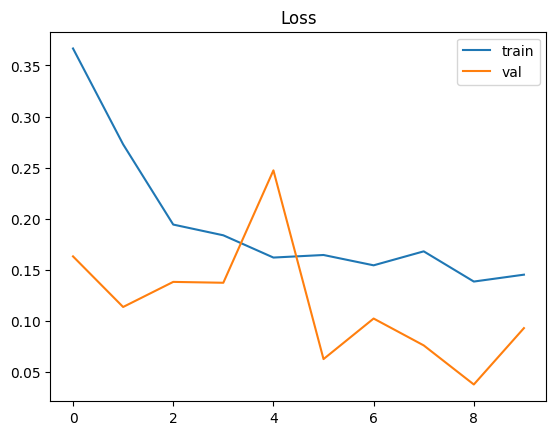

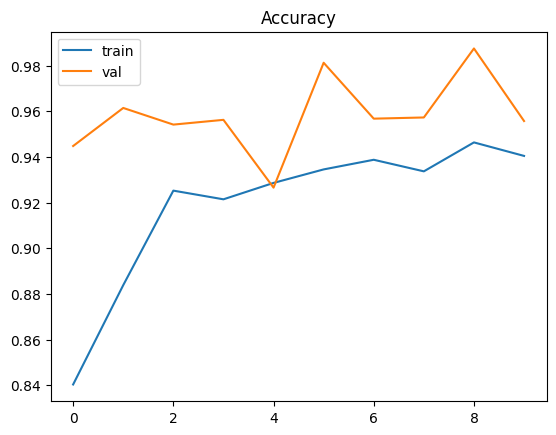

In [ ]:
loaders = {"train": trainloader,
           "val": validloader}

train(model, loaders, optimizer, criterion, epochs=10, dev = device)

### Testing

In [3]:
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(1280, 2)
state_dict = torch.load('C:/Users/aless/Desktop/homework2/model_checkpoint.pth', map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.to(device)
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [5]:
test = datasets.ImageFolder('/content/drive/MyDrive/dataset/test', transform = notransform)
testloader = DataLoader(test, batch_size=64, shuffle=False, drop_last=False)

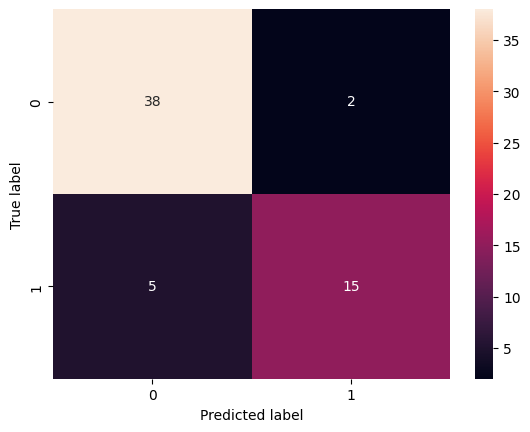

In [ ]:
confusion_matrix = np.zeros((2, 2))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure()
df_cm = pd.DataFrame(confusion_matrix).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [32]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Accuracy {float(num_correct)/float(num_samples)*100:.2f}')

check_accuracy(testloader, model)

Accuracy 88.33


MobileNet trained on the original train set produces 88.33% of accuracy on the test set with 7 misclassified observations, 5 of which belongs to Type-II error. 

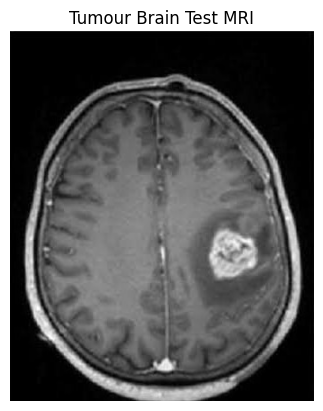

In [5]:
test_img = Image.open('C:/Users/aless/Desktop/homework2/dataset-20230518T093931Z-001/dataset/test/yes/pred8.jpg')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.title('Tumour Brain Test MRI')
plt.axis('off')
plt.show()

In [6]:
test_transform = transforms.Compose([
 transforms.Resize((224, 224)),
 transforms.ToTensor()])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225])

transformed_img = test_transform(test_img)
norm_img = transform_normalize(transformed_img)
input_img = norm_img.unsqueeze(0)
input_img = input_img.to(device)
output = model(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
print(pred_label_idx)

tensor(1)


#### XAI

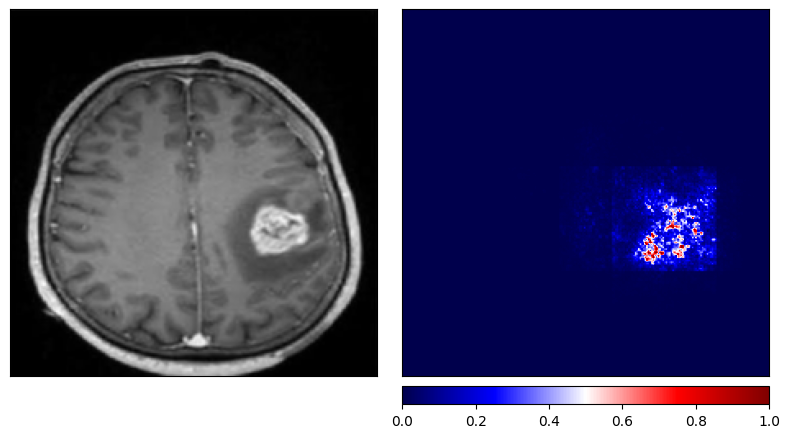

In [9]:
gg = GuidedGradCam(model, model.features[18]) #Guided GradCam on last block 
noise_tunnel = NoiseTunnel(gg) #noise tunnel on Guided GradCam
attributions_ig_nt = noise_tunnel.attribute(input_img, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx, stdevs = 0.2)
#visualize
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)), #noise tunneled Guided GradCam
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)), #unormalized img
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=cm.seismic,
                                      show_colorbar=True)

Finally, a noise tunneled guided GradCam has been applied to understand the behavior of the model on a specific positive test images. In particular, the last block has been analyzed: the feature map related to that convolutional block is able to activates on pixels related to tumour.

## Classification on augmented dataset

In this second step the classifier has been trained on the augmented dataset created by concatenating the original and the synthetic images. 

In [17]:
class ConcatSubfolderDataset(Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, index):
        
        dataset_idx = 0
        while index >= len(self.datasets[dataset_idx]):
            index -= len(self.datasets[dataset_idx])
            dataset_idx += 1

        return self.datasets[dataset_idx][index]

    def __len__(self):
        return sum(len(dataset) for dataset in self.datasets)

path1 = '/content/drive/MyDrive/dataset/synthetic_images'
path2 = '/content/drive/MyDrive/dataset/train'

dataset1 = datasets.ImageFolder(path1)
dataset2 = datasets.ImageFolder(path2)

concatenated_dataset = ConcatSubfolderDataset(dataset1, dataset2)

In [19]:
generator = torch.Generator().manual_seed(46)
train_aug, validation_aug = random_split(concatenated_dataset, [0.8, 0.2], generator = generator)
trainset_aug = loadData(train_aug, transform = traintransform)
valset_aug = loadData(validation_aug, transform = notransform)
trainloader_aug = DataLoader(trainset_aug, batch_size=64, shuffle=True, drop_last=True)
validloader_aug = DataLoader(valset_aug, batch_size=64, shuffle=False, drop_last=False)

### Training

The optimizer used for this purpose is Adam with learning rate of 1e-4 and weight decay (L2) of 2e-5 to prevent from overfitting.

In [20]:
model2 = models.mobilenet_v2(pretrained=True)
model2.classifier[1] = nn.Linear(1280, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.0001, weight_decay = 2e-5)

def train(net, loaders, optimizer, criterion, epochs=100, dev=torch.device('cpu')):
    try:
        net = net.to(dev)
        # Initialize history
        history_loss = {"train": [], "val": []}
        history_accuracy = {"train": [], "val": []}
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0}
            sum_accuracy = {"train": 0, "val": 0}
            # Process each split
            for split in ["train", "val"]:
                if split == "train":
                    net.train()
                else:
                    net.eval()
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    outputs = net(input)
                    loss = criterion(outputs, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    preds = torch.argmax(outputs, 1)
                    batch_accuracy = (preds == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val"]}
            # Update history
            for split in ["train", "val"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"Train Loss={epoch_loss['train']:.4f},",
                  f"Train Accuracy={epoch_accuracy['train']:.4f},",
                  f"Validation Loss={epoch_loss['val']:.4f},",
                  f"Validation Accuracy={epoch_accuracy['val']:.4f},")
            # Save checkpoint
            torch.save(model2.state_dict(), 'model2_checkpoint.pth')
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 34.0MB/s]


Epoch 1: Train Loss=0.4152, Train Accuracy=0.7959, Validation Loss=0.2435, Validation Accuracy=0.8841,
Epoch 2: Train Loss=0.2859, Train Accuracy=0.8626, Validation Loss=0.1883, Validation Accuracy=0.9132,
Epoch 3: Train Loss=0.2426, Train Accuracy=0.8967, Validation Loss=0.1394, Validation Accuracy=0.9324,
Epoch 4: Train Loss=0.2101, Train Accuracy=0.9094, Validation Loss=0.1057, Validation Accuracy=0.9555,
Epoch 5: Train Loss=0.2158, Train Accuracy=0.9034, Validation Loss=0.1245, Validation Accuracy=0.9447,
Epoch 6: Train Loss=0.2046, Train Accuracy=0.9101, Validation Loss=0.0996, Validation Accuracy=0.9553,
Epoch 7: Train Loss=0.1856, Train Accuracy=0.9216, Validation Loss=0.0961, Validation Accuracy=0.9649,
Epoch 8: Train Loss=0.1751, Train Accuracy=0.9232, Validation Loss=0.0945, Validation Accuracy=0.9589,
Epoch 9: Train Loss=0.1607, Train Accuracy=0.9289, Validation Loss=0.0857, Validation Accuracy=0.9663,
Epoch 10: Train Loss=0.1587, Train Accuracy=0.9340, Validation Loss=0.125

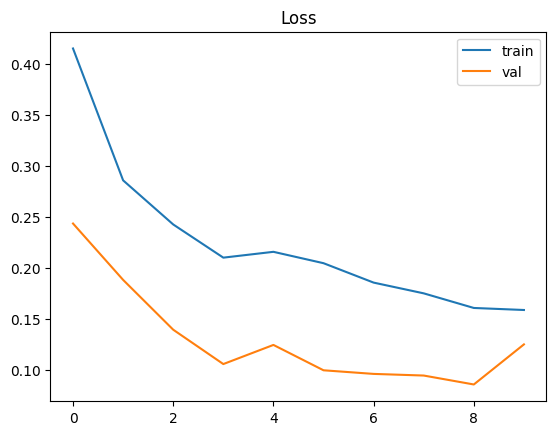

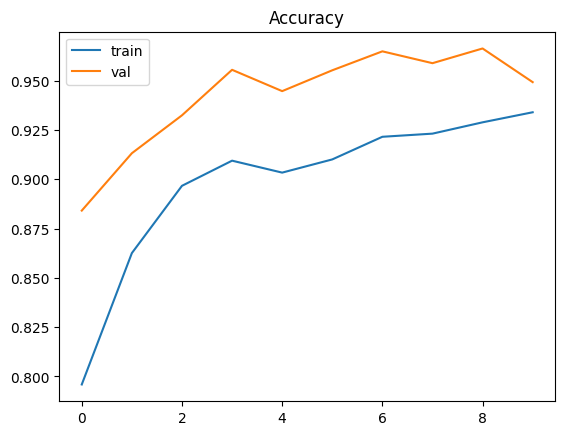

In [21]:
loaders2 = {"train": trainloader_aug,
           "val": validloader_aug}

train(model2, loaders2, optimizer, criterion, epochs=10, dev = device)

### Testing

In [11]:
model2 = models.mobilenet_v2(pretrained=True)
model2.classifier[1] = nn.Linear(1280, 2)
state_dict = torch.load('C:/Users/aless/Desktop/homework2/model2_checkpoint.pth', map_location=torch.device('cpu'))
model2.load_state_dict(state_dict)
model2.to(device)
model2.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

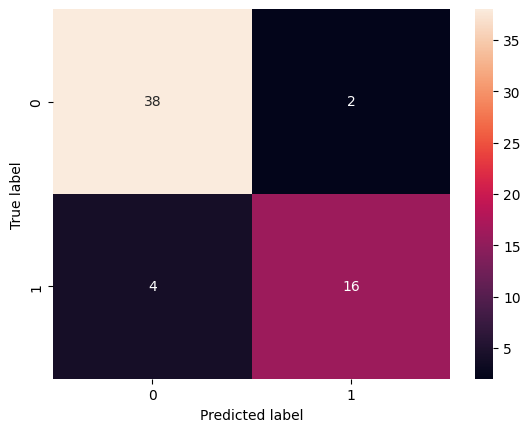

In [24]:
confusion_matrix = np.zeros((2, 2))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model2(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure()
df_cm = pd.DataFrame(confusion_matrix).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [25]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Accuracy {float(num_correct)/float(num_samples)*100:.2f}')

check_accuracy(testloader, model2)

Accuracy 90.00


The classifier related to the augmented dataset produced an accuracy of +2% compared to the previous approach, with a score of 90%. In particular, within 6 misclassified observation, Type-II error is 4 in this case, compared to 5 in the previous case.

In [12]:
test_transform = transforms.Compose([
 transforms.Resize((224, 224)),
 transforms.ToTensor()])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225])

transformed_img = test_transform(test_img)
norm_img = transform_normalize(transformed_img)
input_img = norm_img.unsqueeze(0)
input_img = input_img.to(device)
output = model2(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
print(pred_label_idx)

tensor(1)


#### XAI

c:\Users\aless\AppData\Local\Programs\Python\Python310\lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


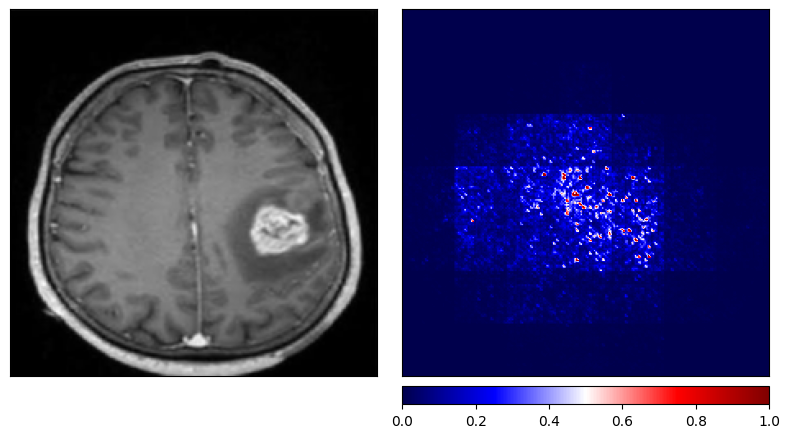

In [19]:
gg = GuidedGradCam(model2, model2.features[18]) #Guided GradCam on last block 
noise_tunnel = NoiseTunnel(gg) #noise tunnel on Guided GradCam
attributions_ig_nt = noise_tunnel.attribute(input_img, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx, stdevs=0.4)
#visualize
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)), #noise tunneled Guided GradCam
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)), #unormalized img
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=cm.seismic,
                                      show_colorbar=True)

Also in this case, to better understands the behavior of the model, a noise tunneled guided gradcam has been applied related to the last convolutional block. While the previous model was more precise in terms of acrtivated pixels, it produced a lower accuracy compared to this model which seems to inspecting a wider space to detect the tumour. However, the behaviour above leads to a +2% accuracy. 